In [5]:
# Import necessary libraries
import pandas as pd
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import numpy as np

In [6]:
# Download stopwords if not already downloaded
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mktmi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
# Check and clean dataset
df.dropna(subset=['text', 'label'], inplace=True)

In [9]:
# Preprocess text (lowercasing, removing punctuation, and stopwords)
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    stop_words = set(stopwords.words('english'))  # Assuming English text
    return [word for word in text.split() if word not in stop_words]

df['cleaned_text'] = df['text'].apply(preprocess_text)

In [10]:
# Train a Word2Vec model on the cleaned text data
word2vec_model = Word2Vec(sentences=df['cleaned_text'], vector_size=100, window=5, min_count=1, workers=4)

In [11]:
# Function to create a feature vector from a list of words using the Word2Vec model
def get_word2vec_vector(words, model, vector_size):
    vector = np.zeros(vector_size)
    count = 0
    for word in words:
        if word in model.wv:
            vector += model.wv[word]
            count += 1
    if count != 0:
        vector /= count
    return vector

In [12]:
# Apply the feature extraction for each text (convert text to Word2Vec vector)
X = np.array([get_word2vec_vector(words, word2vec_model, 100) for words in df['cleaned_text']])
y = df['label']

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
# Initialize and train the SVM model with a linear kernel
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

In [15]:
# Make predictions
y_pred_svm = svm_model.predict(X_test)

In [16]:
# Evaluate the model's performance
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.8026643244034548
              precision    recall  f1-score   support

           0       0.77      0.89      0.82      3529
           1       0.86      0.71      0.78      3302

    accuracy                           0.80      6831
   macro avg       0.81      0.80      0.80      6831
weighted avg       0.81      0.80      0.80      6831



In [17]:
# Save the SVM model and the Word2Vec model for future use
with open('svm_model_word2vec.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

word2vec_model.save("word2vec_model.bin")

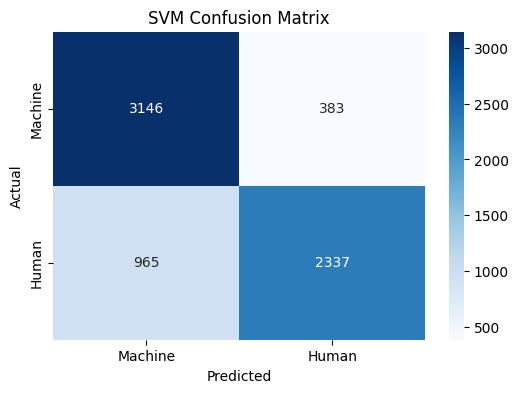

In [18]:
# Confusion Matrix to visualize performance
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Machine', 'Human'], yticklabels=['Machine', 'Human'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')
plt.show()